# ISIC-2018: ResNet50 training

In [2]:
import os
import time
import cv2
import numpy as np
import torch
import torchvision
import torch.optim as optim

%matplotlib inline

import matplotlib.pyplot as plt

### Import ResNet50 model and print the layers

In [3]:
from model_resnet import Net

net = Net(num_classes=1).cuda()
print(net)

/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Net(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

### Load dataset and visualize

In [4]:
import dataset

lesionData = dataset.LesionData()
train_loader, val_loader = lesionData.getTask1TrainingDataLoaders(val_percent = 20, batch_size = 10, augment=True)

print('training_size: %d, validation_size:%d' % (len(train_loader),len(val_loader)) )

training_size: 151, validation_size:38


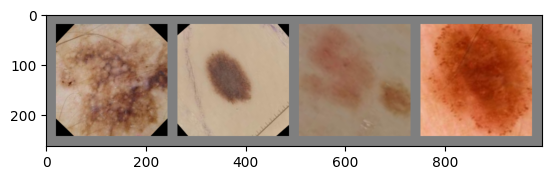

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels, fnames = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[0:4], nrow=4, padding=20))


## Loss functions and metrics

In [6]:
def dice_coef(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (torch.sum(y_true) + torch.sum(y_pred) + 1.)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return (intersection + 1.) / (torch.sum(y_true) + torch.sum(y_pred) - intersection + 1.)

def falsepos(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return torch.sum(y_pred) - intersection

def falseneg(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return torch.sum(y_true) - intersection

def precision(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return intersection / (torch.sum(y_pred) + 1.)

def recall(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return intersection / (torch.sum(y_true) + 1.)

def fscore(y_true, y_pred):
    presci = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*(presci * rec)/(presci + rec)

def weighted_fscore_loss(prew=1, recw=1):
    def fscore_loss(y_true, y_pred):
        presci = precision(y_true, y_pred)
        rec = recall(y_true, y_pred)
        return -(prew+recw)*(presci * rec)/(prew*presci + recw*rec)
    return fscore_loss

### Visualizing losses and metrics with visdom
Run visdom server before executing this

In [7]:
from visualization import Visualization

learning_rate = 1e-5

optimizer = optim.Adam(net.parameters(), lr=learning_rate)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

iou_vis = Visualization('IOU / Dice Coeff.')
fpfn_vis = Visualization('False Positive / False Negative')
fscore_vis = Visualization('Precision, Recall, F-Score')
loss_vis = Visualization('Mean loss')

measures = {
    'dice_coeff': (dice_coef, iou_vis), 
    'iou': (iou, iou_vis), 
    'fp': (falsepos, fpfn_vis), 
    'fn': (falseneg, fpfn_vis), 
    'precision': (precision, fscore_vis), 
    'recall': (recall, fscore_vis), 
    'fscore': (fscore, fscore_vis) }


Setting up a new session...
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_

Setting up a new session...
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_

Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Setting up a new session...
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_

Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


## Training the model
Vary number of frozen layers by naming layers to un-freeze in ```trainable```

Weight the loss function to emphasize precsion or recall by modifying ```fscores``` array

In [8]:
import train

measurement_log = []
fscores = [(2,1),(1,2)]*15 # [(2,1)] * 5 + [(1.5,1)]*5 + [(1,1)]*5 + [(1,1.5)]*5 + [(1,2)]*5
trainable = [['layer2', 'layer3','layer4']]*25 # [['layer4']]*10 + [['layer3','layer4']]*15
# fscores = [(2,1)] * 5 + [(1.5,1)]*5 + [(1,1)]*5 + [(1,1.5)]*5 + [(1,2)]*5
# frozen = [9] * 25

for epoch in range(25):
    net.setTrainableLayers(trainable[epoch])
    measurements = train.fit(net, train_loader, val_loader, weighted_fscore_loss(*(fscores[epoch])), optimizer, lrscheduler, measures, epoch, loss_vis)
    measurement_log.append(measurements)
    print("Epoch: %d: " % epoch, end='')
    for k,v in measurements.items():
        print(" {}:{:.5f}".format(k,v), end=',')
    print()

Exception in user code: # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 0:  dice_coeff:0.41276, iou:0.26309, fp:5674.08992, fn:256981.87788, precision:0.94085, recall:0.26744, fscore:0.41276, train_loss:-0.60343, val_loss:-0.34929,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 1:  dice_coeff:0.71308, iou:0.55985, fp:30916.58134, fn:21188.79551, precision:0.68443, recall:0.75409, fscore:0.71307, train_loss:-0.63124, val_loss:-0.70240,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 2:  dice_coeff:0.79210, iou:0.65978, fp:7596.88050, fn:39753.13245, precision:0.92565, recall:0.70061, fscore:0.79209, train_loss:-0.85087, val_loss:-0.75817,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 3:  dice_coeff:0.82162, iou:0.70140, fp:25240.09408, fn:6530.00578, precision:0.75195, recall:0.91770, fscore:0.82161, train_loss:-0.86511, val_loss:-0.79615,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 4:  dice_coeff:0.85580, iou:0.75048, fp:13780.02642, fn:14605.38559, precision:0.86651, recall:0.85324, fscore:0.85579, train_loss:-0.88964, val_loss:-0.85401,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 5:  dice_coeff:0.84782, iou:0.73893, fp:20221.17378, fn:7868.20456, precision:0.80085, recall:0.90966, fscore:0.84781, train_loss:-0.89186, val_loss:-0.83081,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 6:  dice_coeff:0.85800, iou:0.75517, fp:7166.12372, fn:23156.73052, precision:0.92985, recall:0.80318, fscore:0.85799, train_loss:-0.89888, val_loss:-0.83820,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 7:  dice_coeff:0.86455, iou:0.76406, fp:15989.06867, fn:10136.78182, precision:0.84225, recall:0.89486, fscore:0.86454, train_loss:-0.89851, val_loss:-0.85631,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 8:  dice_coeff:0.87083, iou:0.77443, fp:8722.21166, fn:17736.88050, precision:0.91434, recall:0.83731, fscore:0.87082, train_loss:-0.90694, val_loss:-0.85870,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code: # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:ch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 9:  dice_coeff:0.85850, iou:0.75463, fp:19354.17378, fn:6652.68675, precision:0.80721, recall:0.92438, fscore:0.85848, train_loss:-0.89901, val_loss:-0.84006,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 10:  dice_coeff:0.87711, iou:0.78344, fp:10568.40245, fn:13957.70323, precision:0.89690, recall:0.86393, fscore:0.87710, train_loss:-0.91037, val_loss:-0.87202,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 11:  dice_coeff:0.87658, iou:0.78271, fp:11288.39869, fn:13141.02560, precision:0.88952, recall:0.87019, fscore:0.87657, train_loss:-0.89984, val_loss:-0.88012,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 12:  dice_coeff:0.87597, iou:0.78176, fp:10980.60444, fn:13677.71330, precision:0.89243, recall:0.86589, fscore:0.87596, train_loss:-0.90885, val_loss:-0.87193,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 13:  dice_coeff:0.87541, iou:0.78104, fp:11237.82160, fn:13485.44274, precision:0.88957, recall:0.86790, fscore:0.87540, train_loss:-0.89789, val_loss:-0.87934,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 14:  dice_coeff:0.87637, iou:0.78249, fp:10340.83342, fn:14369.91370, precision:0.89856, recall:0.86095, fscore:0.87636, train_loss:-0.91249, val_loss:-0.87052,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 15:  dice_coeff:0.87712, iou:0.78355, fp:11218.98787, fn:13103.67599, precision:0.89026, recall:0.87034, fscore:0.87711, train_loss:-0.89611, val_loss:-0.88075,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 16:  dice_coeff:0.87682, iou:0.78299, fp:10392.99358, fn:14169.85701, precision:0.89867, recall:0.86174, fscore:0.87681, train_loss:-0.91172, val_loss:-0.87108,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 17:  dice_coeff:0.87708, iou:0.78326, fp:12530.72327, fn:11493.76413, precision:0.87711, recall:0.88322, fscore:0.87707, train_loss:-0.90091, val_loss:-0.87641,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 18:  dice_coeff:0.87713, iou:0.78344, fp:10241.67383, fn:14300.82165, precision:0.90009, recall:0.86103, fscore:0.87712, train_loss:-0.91016, val_loss:-0.87105,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 19:  dice_coeff:0.87677, iou:0.78295, fp:12040.69968, fn:12151.12413, precision:0.88161, recall:0.87817, fscore:0.87676, train_loss:-0.89841, val_loss:-0.87768,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 20:  dice_coeff:0.87763, iou:0.78421, fp:11611.88569, fn:12516.15615, precision:0.88619, recall:0.87494, fscore:0.87762, train_loss:-0.91149, val_loss:-0.87608,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 21:  dice_coeff:0.87490, iou:0.77993, fp:12859.69984, fn:11576.29621, precision:0.87396, recall:0.88234, fscore:0.87489, train_loss:-0.90141, val_loss:-0.87388,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 22:  dice_coeff:0.87791, iou:0.78453, fp:12377.11236, fn:11448.73509, precision:0.87884, recall:0.88291, fscore:0.87790, train_loss:-0.90968, val_loss:-0.87889,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 23:  dice_coeff:0.87840, iou:0.78539, fp:11894.75601, fn:11998.21006, precision:0.88344, recall:0.87937, fscore:0.87839, train_loss:-0.89931, val_loss:-0.87940,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 0        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 30        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 60        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 90        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 120        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:h # 150        
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

Exception in user code:tch # 37      
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Epoch: 24:  dice_coeff:0.87621, iou:0.78212, fp:11289.21114, fn:13236.83059, precision:0.88929, recall:0.86935, fscore:0.87620, train_loss:-0.91124, val_loss:-0.87325,


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connection.py", line 207, in _new_conn
    socket_options=self.socket_options,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 803, in urlopen
    **response_kw,
  File "/home/ubuntu/anaconda3/envs/isic-2018/lib/python3.7/site-packages/urllib3/connectionpool.py", line 505, in _make_request
    enforce_content_length=enforce_content_length,
  File "/home/ubuntu

### Save trained model and measurements

In [9]:
import csv

timestamp = time.strftime('%m%d%H%M')
outputfolder = './output/task1-resnet-%s'%timestamp
os.mkdir(outputfolder)

# write out weights
net.save(os.path.join(outputfolder,'lesions.pth'))

# write out log
with open(os.path.join(outputfolder,'info.txt'), 'w') as f:
    f.write('%s\n' % time.strftime('%m-%d %H:%M'))
    f.write('optimizer: %s\n' % type(optimizer).__name__)
    f.write('scheduler: %s\n' % type(lrscheduler).__name__)
    f.write('learning_rate: %.6f\n' % learning_rate)
    f.write('\n')
    
with open(os.path.join(outputfolder,'measurements.txt'), 'w') as f:
    wr = csv.writer(f)
    wr.writerow(["Epoch"] + list(measurements.keys()))
    for epoch,measurement in enumerate(measurement_log):
        wr.writerow([epoch] + list(measurement.values()))

## Sample some images and show results

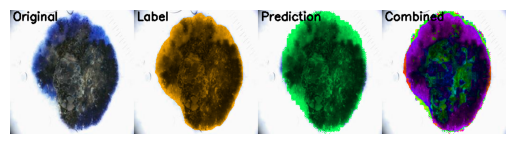

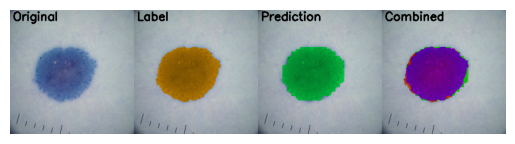

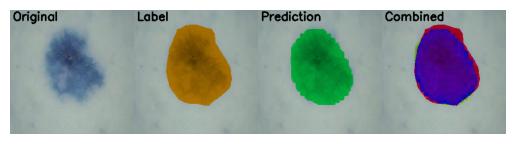

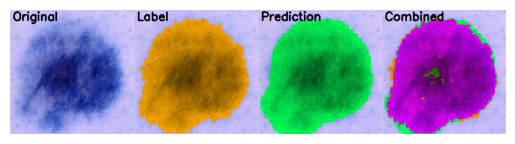

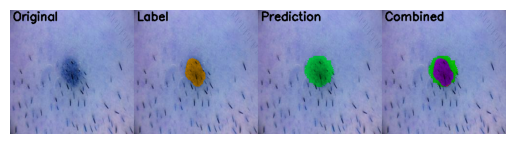

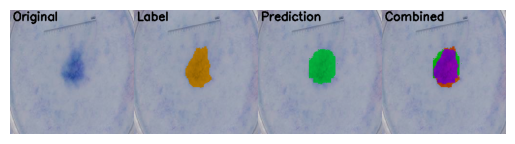

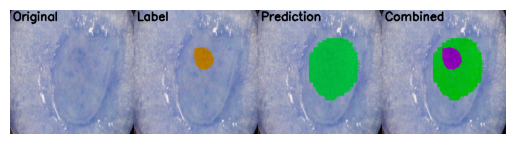

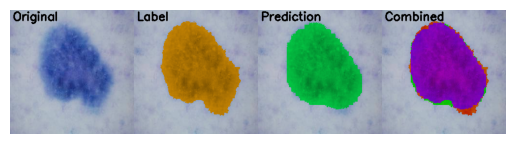

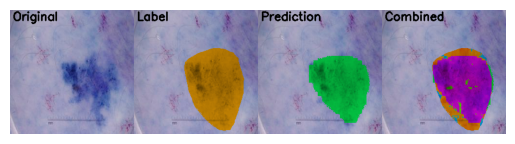

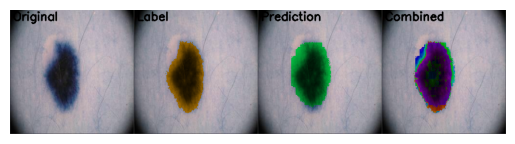

In [10]:
import eval

evaluator = eval.Evaluator(os.path.join(outputfolder,'lesions.pth'), outputfolder)
samples = evaluator.sample()

for idx in range(len(samples)):
    plt.figure()
    plt.axis('off')
    plt.imshow(samples[idx])